<a href="https://colab.research.google.com/github/Hramchenko/ML/blob/master/Copy_of_mnist_conv_vae_log_cuda_orig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip3 install torch torchvision
import torch



In [0]:
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")

Device Tesla K80


In [0]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape, show=True, save_to=None):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    if save_to is not None:
        plt.savefig(save_to)
        
    if show:
        plt.show()
    else:
        plt.close()

    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import os 

%matplotlib inline

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [0]:
root_folder = 'Conv_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [0]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [0]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 2))
fixed_data, _ = next(iter(test_loader))

In [0]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [0]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [0]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [0]:
class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
            
        self.fce = FullyConnected([32*2*2, latent_size*2])
        self.fcd = FullyConnected([latent_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.fce(flatten)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        x = self.decode(h)
        return x
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size]).to(device)
    
    def loss(self, output, target, size_average=True):
        KLD = self.mu**2 + self.logvar.exp() - 1 - self.logvar
        KLD = 0.5*KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
            self._loss = F.mse_loss(output, target, reduction='mean')
        else:
            self.KLD = KLD.sum()
            self._loss = F.mse_loss(output, target, reduction='sum')
        
        return self._loss + self.gamma*self.KLD

In [0]:
models = {'VAE10': Net(2, 0.005, batchnorm=True, dropout=False, optim_type='Adam', lr=1e-4).to(device)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [0]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [0]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()
    
    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                    test_reconstruction_loss[k], 
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        with torch.no_grad():
            ae_data = models[k](fixed_data.to(device)).data.cpu().numpy()
            fixed_gen = models[k].decode(fixed_z.to(device)).data.cpu().numpy()
            plot_mnist(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
            plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses VAE10: 0.1781
Train Epoch: 1 [10000/50000 (20%)]	Losses VAE10: 0.1696
Train Epoch: 1 [20000/50000 (40%)]	Losses VAE10: 0.1741
Train Epoch: 1 [30000/50000 (60%)]	Losses VAE10: 0.1746
Train Epoch: 1 [40000/50000 (80%)]	Losses VAE10: 0.1902
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE10: 0.1815


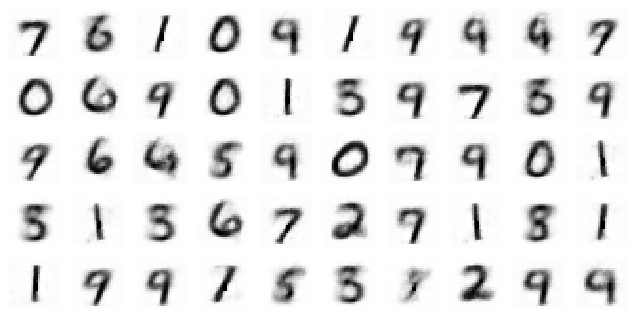

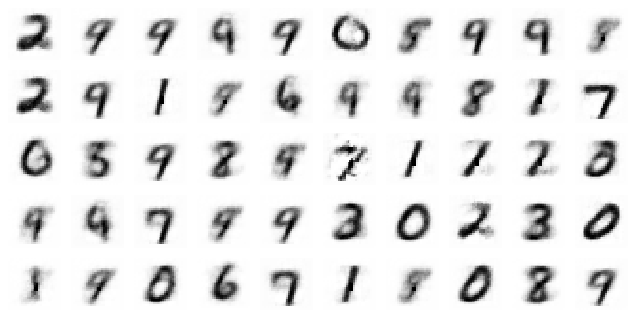

Test losses: VAE10: 0.1684/4.4676
Train Epoch: 2 [0/50000 (0%)]	Losses VAE10: 0.1539
Train Epoch: 2 [10000/50000 (20%)]	Losses VAE10: 0.1720
Train Epoch: 2 [20000/50000 (40%)]	Losses VAE10: 0.1720
Train Epoch: 2 [30000/50000 (60%)]	Losses VAE10: 0.1588
Train Epoch: 2 [40000/50000 (80%)]	Losses VAE10: 0.1716
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE10: 0.1750


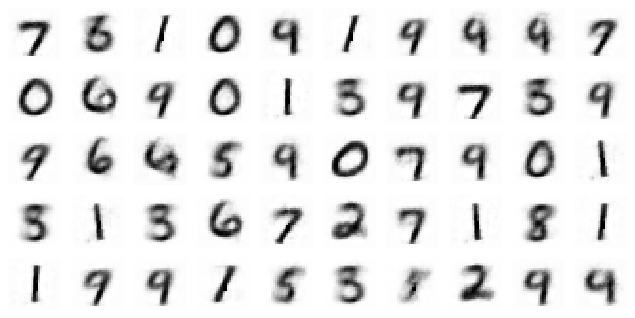

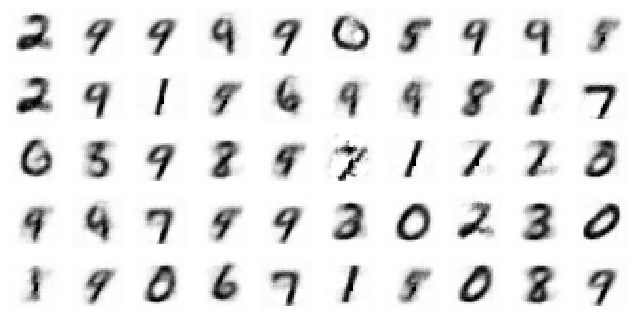

Test losses: VAE10: 0.1686/4.4770
Train Epoch: 3 [0/50000 (0%)]	Losses VAE10: 0.1644
Train Epoch: 3 [10000/50000 (20%)]	Losses VAE10: 0.1783
Train Epoch: 3 [20000/50000 (40%)]	Losses VAE10: 0.1719
Train Epoch: 3 [30000/50000 (60%)]	Losses VAE10: 0.1763
Train Epoch: 3 [40000/50000 (80%)]	Losses VAE10: 0.1745
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE10: 0.1767


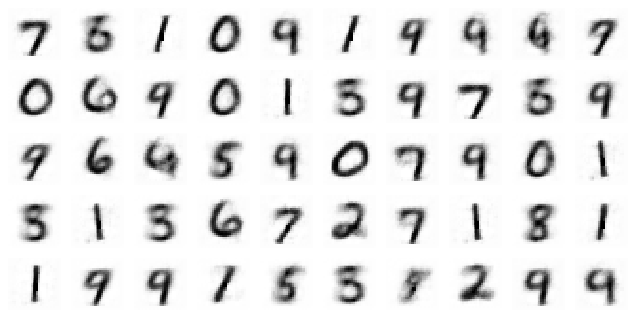

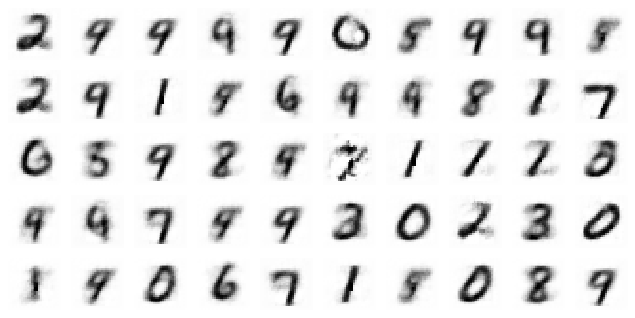

Test losses: VAE10: 0.1682/4.4759
Train Epoch: 4 [0/50000 (0%)]	Losses VAE10: 0.1857
Train Epoch: 4 [10000/50000 (20%)]	Losses VAE10: 0.1432
Train Epoch: 4 [20000/50000 (40%)]	Losses VAE10: 0.1738
Train Epoch: 4 [30000/50000 (60%)]	Losses VAE10: 0.2022
Train Epoch: 4 [40000/50000 (80%)]	Losses VAE10: 0.1731
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE10: 0.1706


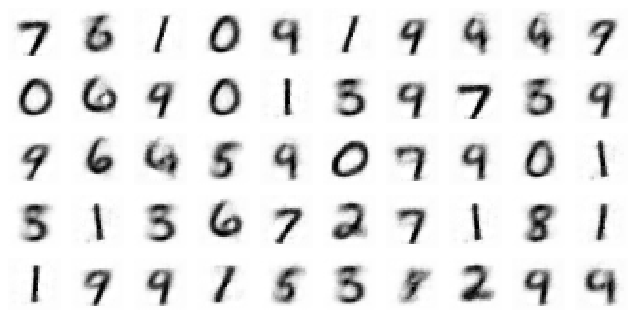

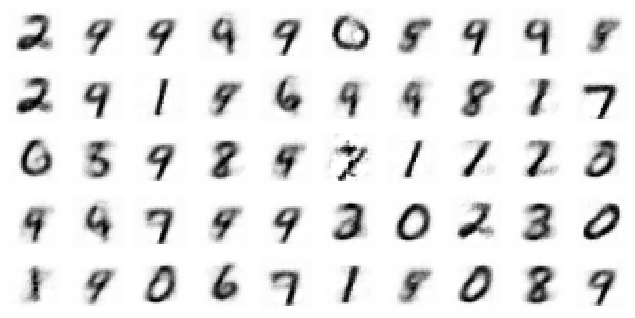

Test losses: VAE10: 0.1676/4.4597
Train Epoch: 5 [0/50000 (0%)]	Losses VAE10: 0.1743
Train Epoch: 5 [10000/50000 (20%)]	Losses VAE10: 0.1753
Train Epoch: 5 [20000/50000 (40%)]	Losses VAE10: 0.1776
Train Epoch: 5 [30000/50000 (60%)]	Losses VAE10: 0.1685
Train Epoch: 5 [40000/50000 (80%)]	Losses VAE10: 0.1698
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE10: 0.1679


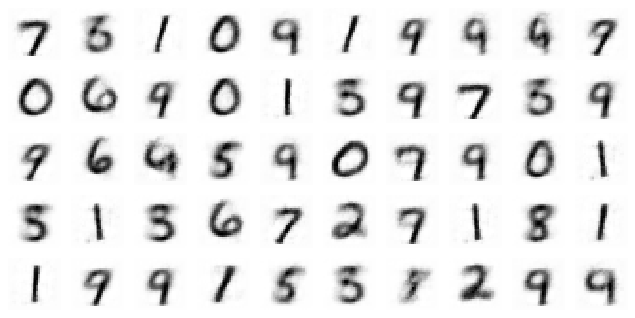

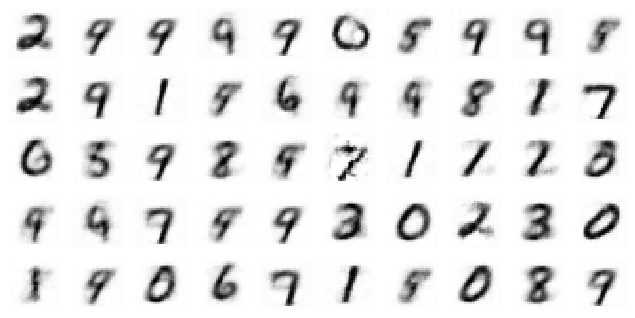

Test losses: VAE10: 0.1672/4.5092
Train Epoch: 6 [0/50000 (0%)]	Losses VAE10: 0.1570
Train Epoch: 6 [10000/50000 (20%)]	Losses VAE10: 0.1716
Train Epoch: 6 [20000/50000 (40%)]	Losses VAE10: 0.1676
Train Epoch: 6 [30000/50000 (60%)]	Losses VAE10: 0.1620
Train Epoch: 6 [40000/50000 (80%)]	Losses VAE10: 0.1746
Train Epoch: 6 [50000/50000 (100%)]	Losses VAE10: 0.1679


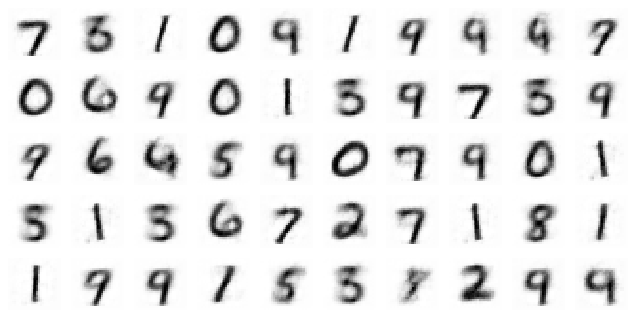

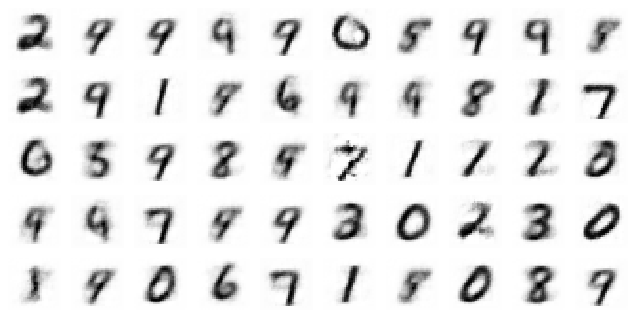

Test losses: VAE10: 0.1667/4.4985
Train Epoch: 7 [0/50000 (0%)]	Losses VAE10: 0.1584
Train Epoch: 7 [10000/50000 (20%)]	Losses VAE10: 0.1583
Train Epoch: 7 [20000/50000 (40%)]	Losses VAE10: 0.1926
Train Epoch: 7 [30000/50000 (60%)]	Losses VAE10: 0.1714
Train Epoch: 7 [40000/50000 (80%)]	Losses VAE10: 0.1664
Train Epoch: 7 [50000/50000 (100%)]	Losses VAE10: 0.1767


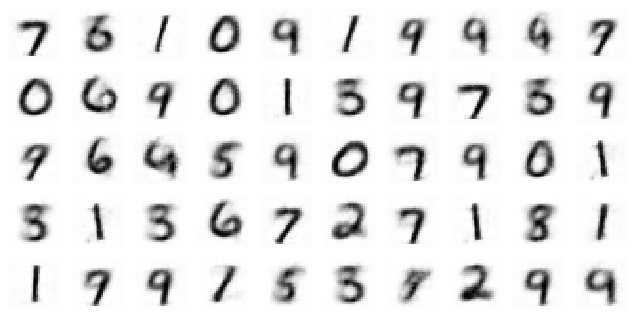

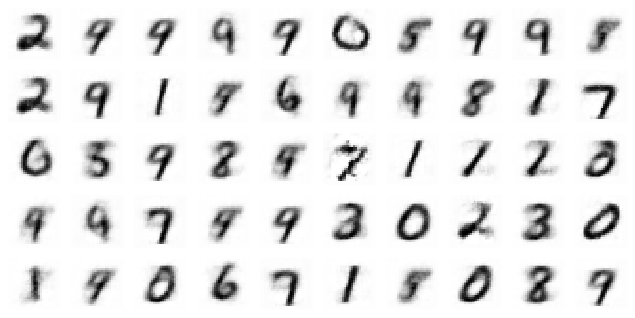

Test losses: VAE10: 0.1665/4.5374
Train Epoch: 8 [0/50000 (0%)]	Losses VAE10: 0.1700
Train Epoch: 8 [10000/50000 (20%)]	Losses VAE10: 0.1894
Train Epoch: 8 [20000/50000 (40%)]	Losses VAE10: 0.1599
Train Epoch: 8 [30000/50000 (60%)]	Losses VAE10: 0.1579
Train Epoch: 8 [40000/50000 (80%)]	Losses VAE10: 0.1718
Train Epoch: 8 [50000/50000 (100%)]	Losses VAE10: 0.1549


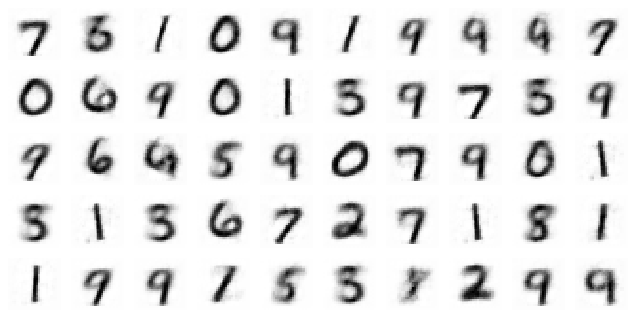

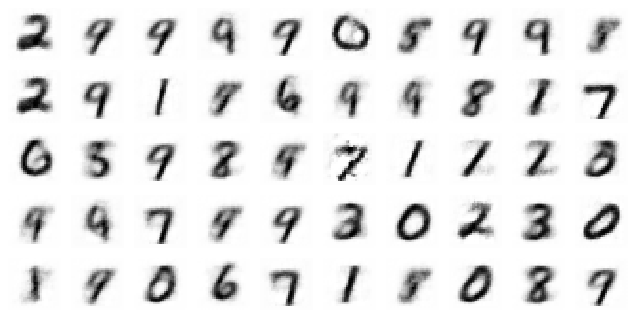

Test losses: VAE10: 0.1664/4.5050
Train Epoch: 9 [0/50000 (0%)]	Losses VAE10: 0.1758
Train Epoch: 9 [10000/50000 (20%)]	Losses VAE10: 0.1752
Train Epoch: 9 [20000/50000 (40%)]	Losses VAE10: 0.1659
Train Epoch: 9 [30000/50000 (60%)]	Losses VAE10: 0.1616
Train Epoch: 9 [40000/50000 (80%)]	Losses VAE10: 0.1647
Train Epoch: 9 [50000/50000 (100%)]	Losses VAE10: 0.1685


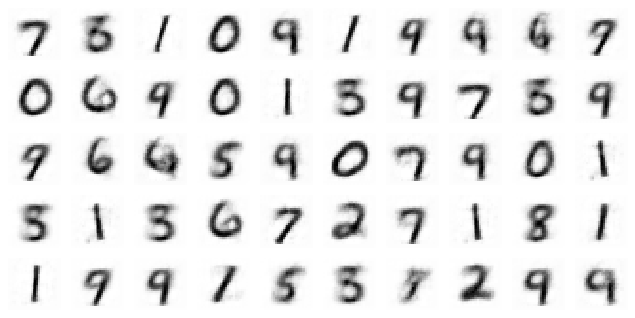

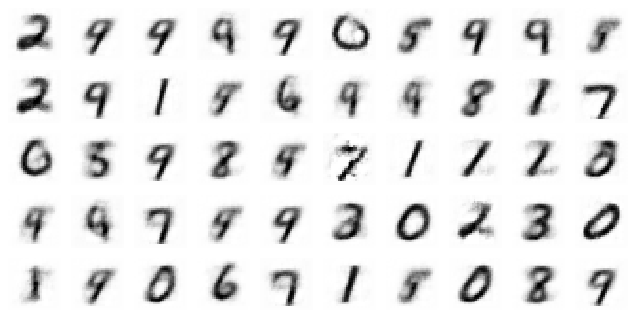

Test losses: VAE10: 0.1665/4.5620
Train Epoch: 10 [0/50000 (0%)]	Losses VAE10: 0.1592
Train Epoch: 10 [10000/50000 (20%)]	Losses VAE10: 0.1578
Train Epoch: 10 [20000/50000 (40%)]	Losses VAE10: 0.1896
Train Epoch: 10 [30000/50000 (60%)]	Losses VAE10: 0.1883
Train Epoch: 10 [40000/50000 (80%)]	Losses VAE10: 0.1676
Train Epoch: 10 [50000/50000 (100%)]	Losses VAE10: 0.1730


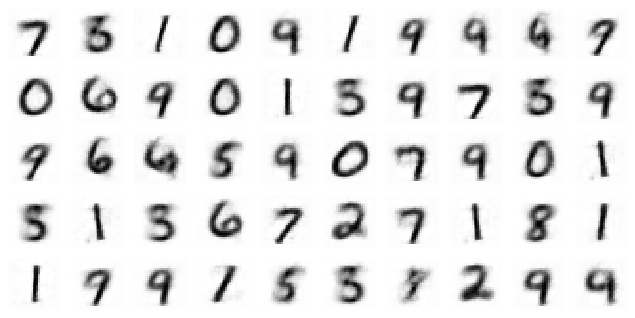

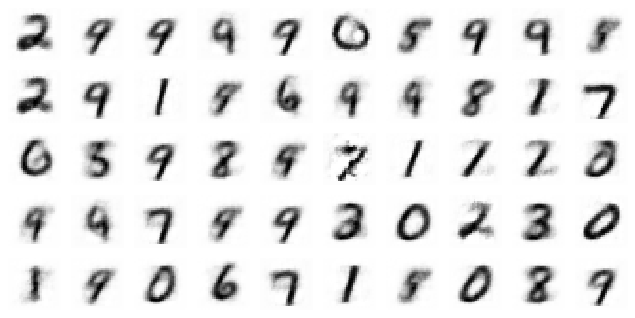

Test losses: VAE10: 0.1652/4.5864
Train Epoch: 11 [0/50000 (0%)]	Losses VAE10: 0.1616


In [0]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)

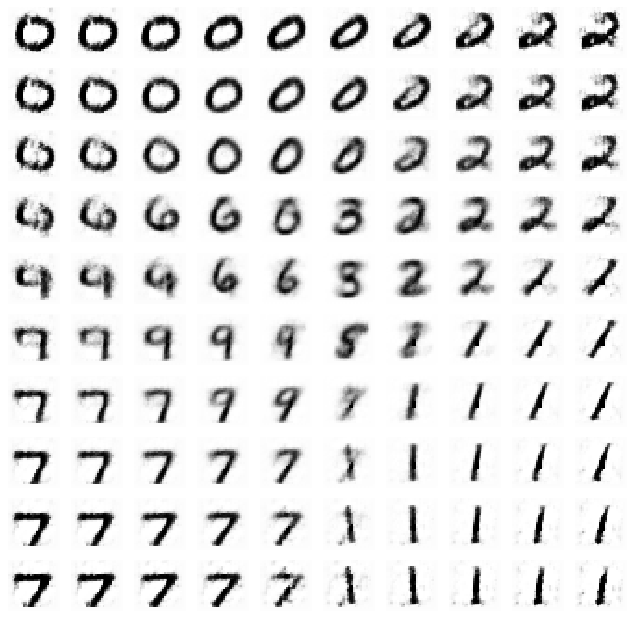

In [0]:
x = np.linspace(-3, 3, 10)
y = np.linspace(-3, 3, 10)
xv, yv = np.meshgrid(x, y)
NPA = np.hstack([xv.reshape([1,-1]).T, yv.reshape([1,-1]).T])
r = torch.FloatTensor(NPA)
with torch.no_grad():
  fixed_gen = models['VAE10'].decode(r.to(device)).data.cpu().numpy()
  plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '/%s_%03d.png' % (0, epoch))